In [ ]:
# !pip install fastai --upgrade

In [ ]:
# !unzip drive/MyDrive/models.zip

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from skimage.color import lab2rgb

import torch
from torchvision import transforms
from torchvision.models.resnet import resnet18

from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet

In [ ]:
SIZE = 256

In [ ]:
def build_generator(n_inputs, n_outputs, core):
  body = create_body(core, pretrained=True, n_in=n_inputs, cut=-2)

  return DynamicUnet(body, n_outputs, (SIZE, SIZE))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def lab_to_rgb(L, ab): 
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

In [ ]:
G = build_generator(1, 2, resnet18).to(device)

G.load_state_dict(torch.load("models/14_G_1620021100.248362.pt", map_location=device))

print(G)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [ ]:
inputs = [Image.open(f"./images/{i}.png") for i in range(1, 11)]
labels = [Image.open(f"./images/{i}.jpg") for i in range(1, 11)]

tensors = torch.empty(0, 1, SIZE, SIZE).to(device)

for img in inputs:
  t = (2 * (transforms.ToTensor()(img))[0] - 1).unsqueeze(0).unsqueeze(0).to(device)
  tensors = torch.cat((tensors, t), dim=0)

print(tensors.shape)

torch.Size([10, 1, 256, 256])


In [ ]:
outputs = G(tensors)

print(outputs.shape)

torch.Size([10, 2, 256, 256])


In [ ]:
prediction_imgs = lab_to_rgb(tensors, outputs.detach())

print(prediction_imgs.shape)

(10, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


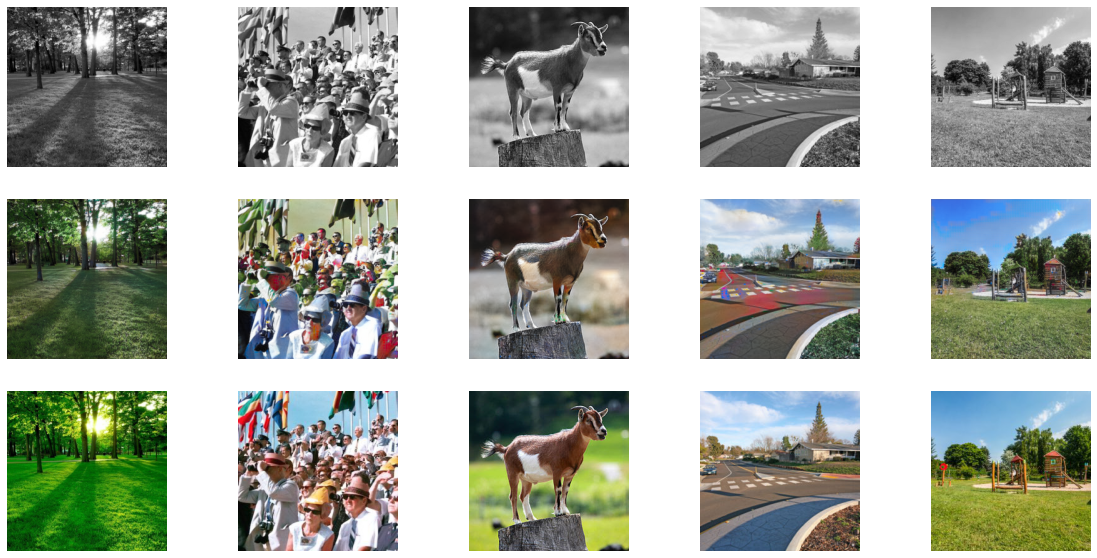

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i in range(5):
  ax = plt.subplot(3, 5, i + 1)
  ax.imshow(tensors[i][0].cpu(), cmap="gray")
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 5)
  ax.imshow(prediction_imgs[i])
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 10)
  ax.imshow(labels[i])
  ax.axis("off")

plt.show()

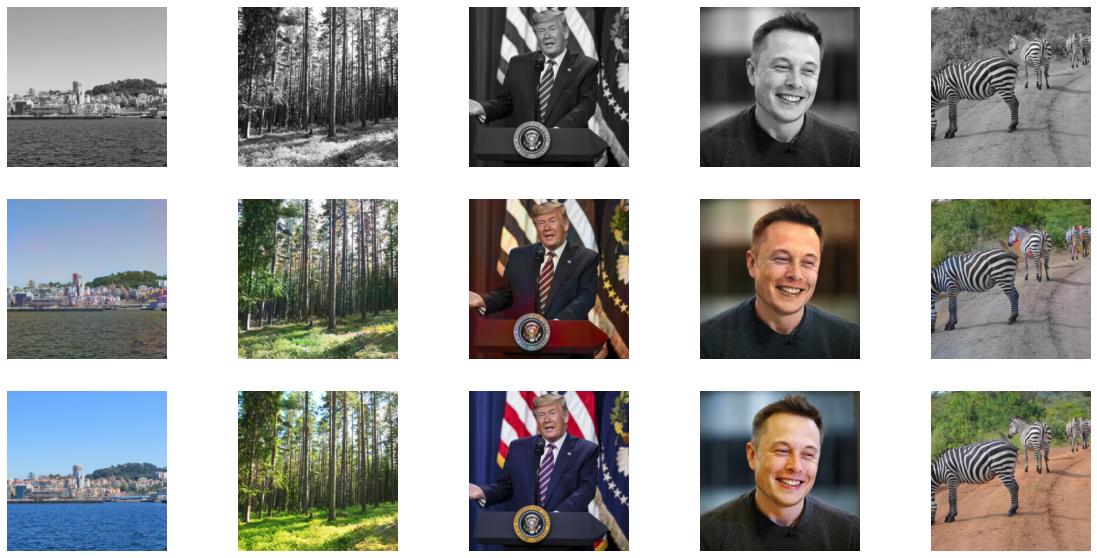

In [ ]:
fig = plt.figure(figsize=(20, 10))

for i in range(5):
  ax = plt.subplot(3, 5, i + 1)
  ax.imshow(tensors[i + 5][0].cpu(), cmap="gray")
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 5)
  ax.imshow(prediction_imgs[i + 5])
  ax.axis("off")
  ax = plt.subplot(3, 5, i + 1 + 10)
  ax.imshow(labels[i + 5])
  ax.axis("off")

plt.show()